In [1]:
import keras_tuner as kt
import pandas as pd
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import shap

In [2]:
####################################################### load dataframe
# Load dataset from ppi.csv
df = pd.read_csv("ppi.csv")

print(df.columns)

Index(['Unnamed: 0', 'domain', 'aa_ProtPosition', 'uniprot_id', 'Rlength',
       'sequence', 'normalized_length', 'normalized_abs_surf_acc',
       'normalized_hydropathy_index', 'rel_surf_acc',
       ...
       '9_wm_pssm_K', '9_wm_pssm_M', '9_wm_pssm_F', '9_wm_pssm_P',
       '9_wm_pssm_S', '9_wm_pssm_T', '9_wm_pssm_W', '9_wm_pssm_Y',
       '9_wm_pssm_V', 'p_interface'],
      dtype='object', length=138)


In [3]:
####################################################### fix sequence in DF
# Define the set of standard amino acids
standard_aas = set("ACDEFGHIKLMNPQRSTVWY")

# detect non-standard amino acids in a sequence (here, each sequence is a single letter)
def has_non_standard(seq):
    return seq not in standard_aas

# identify rows where sequence contains a non-standard amino acid
non_standard_mask = df["sequence"].apply(has_non_standard)

if non_standard_mask.any():
    print("Found non-standard amino acids in the following rows:")
    print(df.loc[non_standard_mask, ["uniprot_id", "sequence"]])
    # Remove rows with non-standard amino acids
    df = df.loc[~non_standard_mask].copy()
else:
    print("All sequences contain standard amino acids.")
    

seq_dummies = pd.get_dummies(df["sequence"], prefix="aa")

# Ensure that we have columns for all 20 standard amino acids (in case some letters are missing in the data)
aa_order = "ACDEFGHIKLMNPQRSTVWY"
expected_cols = [f"aa_{aa}" for aa in aa_order]
seq_dummies = seq_dummies.reindex(columns=expected_cols, fill_value=0)

# Drop the original sequence column and concatenate the one-hot encoded columns
df = df.drop(columns=["sequence"])
df = pd.concat([df, seq_dummies], axis=1)



Found non-standard amino acids in the following rows:
      uniprot_id sequence
29636     Q01786        X



Class Distribution:
p_interface
0    57304
1     7845
Name: count, dtype: int64


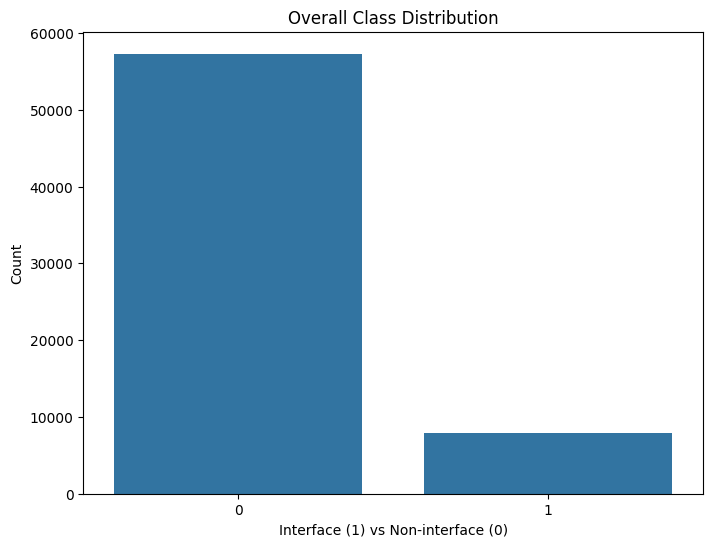

In [4]:
######################################################## check overall class distrubution
# Check overall class distribution for the target
target = "p_interface"
class_counts = df[target].value_counts()
print("\nClass Distribution:")
print(class_counts)

# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=df)
plt.title("Overall Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()

In [ ]:
########################################################## make train, validation and test split
# Count the number of unique proteins based on uniprot_id
unique_proteins = df['uniprot_id'].nunique()
print("\nNumber of Unique Proteins (uniprot_id):", unique_proteins)

# Explore the class distribution per protein
protein_class_distribution = df.groupby('uniprot_id')[target].value_counts().unstack().fillna(0)
print("\nProtein-wise Class Distribution (first 5 proteins):")
print(protein_class_distribution.head())

# Define target and keep uniprot_id for splitting (we'll drop it later)
target = "p_interface"

# Get unique uniprot_ids to use as groups
unique_groups = df['uniprot_id'].unique()

# First split: 80% train and 20% temporary (which will be split into validation and test)
train_groups, temp_groups= train_test_split(unique_groups, test_size=0.2, random_state=22)

# Second split: Split the temporary groups into validation and test equally (10% each)
val_groups, test_groups = train_test_split(temp_groups, test_size=0.5, random_state=42)

# Create the train, validation, and test dataframes by filtering on uniprot_id groups
train_df = df[df['uniprot_id'].isin(train_groups)]
val_df   = df[df['uniprot_id'].isin(val_groups)]
test_df  = df[df['uniprot_id'].isin(test_groups)]

########
train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
val_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])

# Define features and target for each split.
# Drop the columns "uniprot_id", "domain", etc.
X_train = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train = train_df[target]

X_val = val_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_val = val_df[target]

X_test = test_df.drop(columns=[target, "uniprot_id", "domain", "aa_ProtPosition", "Rlength", "Unnamed: 0"])
y_test = test_df[target]


Number of Unique Proteins (uniprot_id): 228

Protein-wise Class Distribution (first 5 proteins):
p_interface    0   1
uniprot_id          
A0A010       185  75
A0A024RAV5   175  13
A0A0D5YE19   290  26
A0A0F4FI39   324  10
A0A0H2VDD2   199   8


In [6]:
####################################### calcualte class weight of train on the validation
class_weights = compute_class_weight("balanced", classes=np.unique(y_val), y=y_val)
class_weights = {cls: weight for cls, weight in zip(np.unique(y_val), class_weights)}
print(class_weights)

{np.int64(0): np.float64(0.575627174510163), np.int64(1): np.float64(3.805690072639225)}


In [7]:
######################################### check overlap

# Check that the splits have disjoint uniprot_ids
train_ids = set(train_df['uniprot_id'])
val_ids   = set(val_df['uniprot_id'])
test_ids  = set(test_df['uniprot_id'])

print("Overlap between Train & Validation:", train_ids.intersection(val_ids))
print("Overlap between Train & Test:", train_ids.intersection(test_ids))
print("Overlap between Validation & Test:", val_ids.intersection(test_ids))

print("Unique uniprot_ids in Train:", train_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Validation:", val_df["uniprot_id"].nunique())
print("Unique uniprot_ids in Test:", test_df["uniprot_id"].nunique())

Overlap between Train & Validation: set()
Overlap between Train & Test: set()
Overlap between Validation & Test: set()
Unique uniprot_ids in Train: 182
Unique uniprot_ids in Validation: 23
Unique uniprot_ids in Test: 23



Class Distribution:
Class 0: 45449 samples (88.00%)
Class 1: 6196 samples (12.00%)


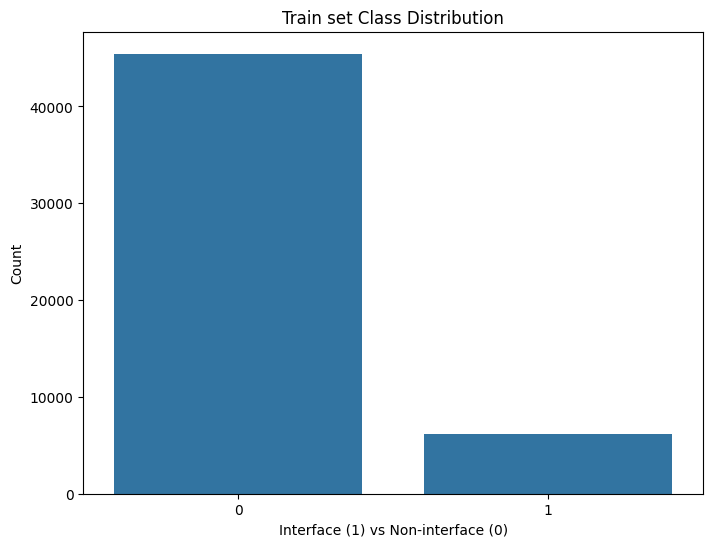

In [8]:
######################################################## check class distrubution for training set
target = "p_interface"
initial_class_counts = train_df[target].value_counts()
initial_class_percentages = train_df[target].value_counts(normalize=True) * 100

print("\nClass Distribution:")
for cls, count in initial_class_counts.items():
    percentage = initial_class_percentages[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


# Visualize the overall class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=train_df)
plt.title("Train set Class Distribution")
plt.xlabel("Interface (1) vs Non-interface (0)")
plt.ylabel("Count")
plt.show()


In [9]:
######################################### Undersampling and Ovesampling
import random
random.seed(42)
#Compute the number of interface occurrences per protein in the training set.
#Since target is binary (0 or 1), summing gives the count for interface per protein.
protein_interface_counts = train_df.groupby("uniprot_id")[target].sum()

# Calculate mean interface counts 
mean_counts = protein_interface_counts.mean()

# Define threshold for Undersampling
threshold_under = mean_counts 
print("Threshold for Undersampling:", threshold_under)

# Define threshold for Oversampling 
threshold_over = mean_counts * 1.5
print("Threshold for Oversampling:", threshold_over)


#Group proteins based on whether their interface count is <= threshold or > threshold (UNDERSAMPLING)
group_low_under = protein_interface_counts[protein_interface_counts <= threshold_under].index.tolist()
group_high_under = protein_interface_counts[protein_interface_counts > threshold_under].index.tolist()

#Group proteins based on whether their interface count is <= threshold or > threshold (OVERSAMPLING)
group_low_over = protein_interface_counts[protein_interface_counts <= threshold_over].index.tolist()
group_high_over = protein_interface_counts[protein_interface_counts > threshold_over].index.tolist()

print("Number of proteins in group_low (<= threshold) for Undersampling:", len(group_low_under))
print("Number of proteins in group_high (> threshold) for Undersampling:", len(group_high_under))

print("Number of proteins in group_low (<= threshold) for Oversampling:", len(group_low_over))
print("Number of proteins in group_high (> threshold) for Oversampling:", len(group_high_over))


# Randomly sample proteins from group low (Undersampling)
# number of proteins to sample
sample_size = 60 
# Randomly sample proteins from group_low
group_low_undersampled = random.sample(group_low_under, min(sample_size, len(group_low_under)))


# Manually define how many proteins to add (Oversampling)
k_num = 50

# Randomly oversample group_high
group_high_duplicates = random.choices(group_high_over, k= k_num)


# Combine the low group undersampled and the original high group - for Undersampling
selected_proteins_under = list(group_low_undersampled) + list(group_high_under)
print("Number of proteins after undersampling:", len(selected_proteins_under))

# Combine the original low group with the oversampled proteins of the high group - for Oversampling
selected_proteins_over = list(group_high_over) + list(group_low_over) + list(group_high_duplicates)
print("Number of proteins after oversampling:", len(selected_proteins_over))


train_df_undersampled = train_df[train_df['uniprot_id'].isin(selected_proteins_under)]
train_df_oversampled = train_df[train_df['uniprot_id'].isin(selected_proteins_over)]

class_counts_u = train_df_undersampled[target].value_counts()
class_percentages_u = train_df_undersampled[target].value_counts(normalize=True) * 100

print("\nClass Distribution after Undersampling:")
for cls, count in class_counts_u.items():
    percentage = class_percentages_u[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")

class_counts_o = train_df_oversampled[target].value_counts()
class_percentages_o = train_df_oversampled[target].value_counts(normalize=True) * 100

print("\nClass Distribution after Oversampling:")
for cls, count in class_counts_o.items():
    percentage = class_percentages_o[cls]
    print(f"Class {cls}: {count} samples ({percentage:.2f}%)")


Threshold for Undersampling: 34.043956043956044
Threshold for Oversampling: 51.065934065934066
Number of proteins in group_low (<= threshold) for Undersampling: 103
Number of proteins in group_high (> threshold) for Undersampling: 79
Number of proteins in group_low (<= threshold) for Oversampling: 143
Number of proteins in group_high (> threshold) for Oversampling: 39
Number of proteins after undersampling: 139
Number of proteins after oversampling: 232

Class Distribution after Undersampling:
Class 0: 34324 samples (86.17%)
Class 1: 5507 samples (13.83%)

Class Distribution after Oversampling:
Class 0: 45449 samples (88.00%)
Class 1: 6196 samples (12.00%)


In [10]:
# Define features and target for training set after undersampling and oversampling
X_train_undersampled = train_df_undersampled.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train_undersampled = train_df_undersampled[target]

X_train_oversampled = train_df_oversampled.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength","Unnamed: 0" ])
y_train_oversampled = train_df_oversampled[target]


<Figure size 800x500 with 0 Axes>

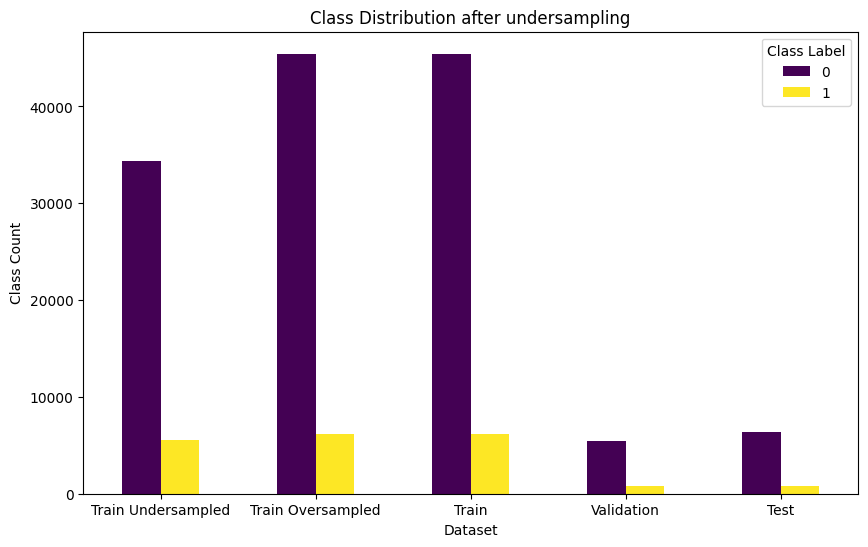

In [11]:
# Count occurrences of each class in train, val, and test sets
train_counts_under = y_train_undersampled.value_counts().sort_index()
train_counts_over = y_train_oversampled.value_counts().sort_index()
train_counts = y_train.value_counts().sort_index()
val_counts = y_val.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Create a DataFrame for visualization
class_distribution = pd.DataFrame({
    "Train Undersampled": train_counts_under,
    "Train Oversampled": train_counts_over,
    "Train": train_counts,
    "Validation": val_counts,
    "Test": test_counts
}).T  # Transpose for better plotting

# Plot the class distribution
plt.figure(figsize=(8, 5))
class_distribution.plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.xlabel("Dataset")
plt.ylabel("Class Count")
plt.title("Class Distribution after undersampling")
plt.xticks(rotation=0)
plt.legend(title="Class Label")
plt.show()


In [12]:
################################################## scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train_undersampled = scaler.fit_transform(X_train_undersampled)
X_train_oversampled = scaler.fit_transform(X_train_oversampled)
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

Confusion Matrix:
[[6394    0]
 [ 823    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



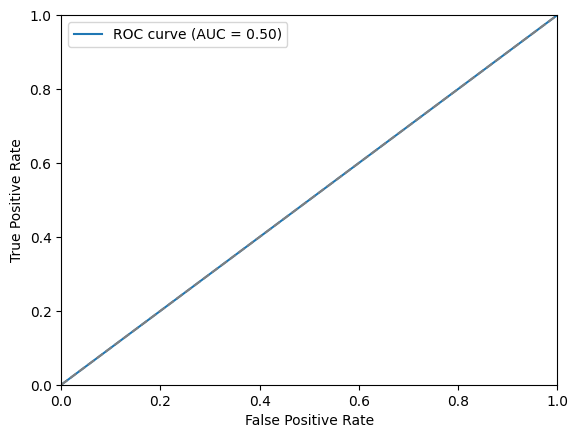

In [54]:
################################################## Dummy Classifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Create a majority class classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit on the training data
dummy_clf.fit(X_train, y_train)

# Predict on the test set
#y_pred_dummy = dummy_clf.predict(X_test)
# Predict probabilities for the positive class (class 1)
y_prob_dummy = dummy_clf.predict_proba(X_test)[:, 1]
# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_dummy = (y_prob_dummy >= 0.5).astype(int)


# Compute ROC curve and AUC
fpr_dummy, tpr_dummy, thresholds_dummy = roc_curve(y_test, y_pred_dummy)
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_prob_dummy))
print("\nClassification Report:")
print(classification_report(y_test, y_prob_dummy, zero_division=0))

plt.plot(fpr_dummy, tpr_dummy, label=f"ROC curve (AUC = {roc_auc_dummy:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [42]:
#################################################### Logistic regression 
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix

# Initialize and fit the Logistic Regression model
model = model = LogisticRegression( 
    max_iter=10000,       
    class_weight='balanced' 
)
model.fit(X_train, y_train)

# Predict probabilities for the positive class
y_pred_proba_LR = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_LR = (y_pred_proba_LR >= 0.5).astype(int)


# Calculate log loss
loss = log_loss(y_test, y_pred_proba_LR)
print("Log Loss: {:.4f}".format(loss))

# Calculate accuracy for reference
accuracy = accuracy_score(y_test, y_pred_LR)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_LR))

# Confusion matrix for more insight
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_LR))


Log Loss: 0.5301
Accuracy: 72.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      6394
           1       0.20      0.49      0.29       823

    accuracy                           0.72      7217
   macro avg       0.56      0.62      0.56      7217
weighted avg       0.84      0.72      0.77      7217


Confusion Matrix:
[[4825 1569]
 [ 423  400]]


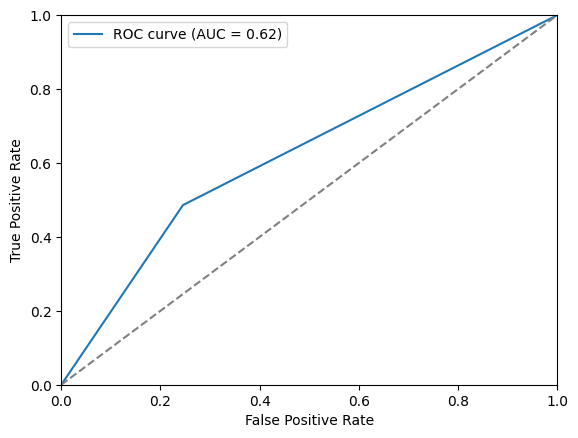

In [43]:
################################################# print results Logistic regression

# Compute ROC curve with continuous probabilities
fpr_LR, tpr_LR, thresholds = roc_curve(y_test, y_pred_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

plt.plot(fpr_LR, tpr_LR, label=f"ROC curve (AUC = {roc_auc_LR:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Log Loss: 0.5375
Accuracy: 72.32%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      6394
           1       0.20      0.48      0.29       823

    accuracy                           0.72      7217
   macro avg       0.56      0.62      0.56      7217
weighted avg       0.84      0.72      0.77      7217


Confusion Matrix:
[[4820 1574]
 [ 424  399]]


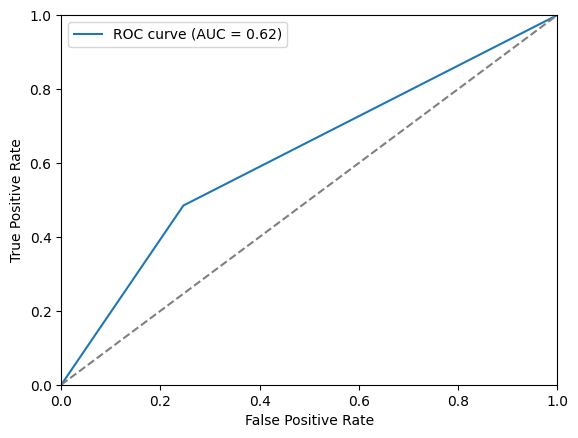

In [41]:
#################################################### Logistic regression - Undersampled Training set 
# Initialize and fit the Logistic Regression model
model = model = LogisticRegression( 
    max_iter=10000,       
    class_weight='balanced' 
)
model.fit(X_train_undersampled, y_train_undersampled)

# Predict probabilities for the positive class
y_pred_proba_LR_under = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_LR_under = (y_pred_proba_LR_under >= 0.5).astype(int)


# Calculate log loss
loss = log_loss(y_test, y_pred_proba_LR_under)
print("Log Loss: {:.4f}".format(loss))

# Calculate accuracy for reference
accuracy = accuracy_score(y_test, y_pred_LR_under)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_LR_under))

# Confusion matrix for more insight
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_LR_under))


# Compute ROC curve with continuous probabilities
fpr_LR_under, tpr_LR_under, thresholds_under = roc_curve(y_test, y_pred_LR_under)
roc_auc_LR_under = auc(fpr_LR_under, tpr_LR_under)

plt.plot(fpr_LR_under, tpr_LR_under, label=f"ROC curve (AUC = {roc_auc_LR_under:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


Log Loss: 0.5301
Accuracy: 72.40%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      6394
           1       0.20      0.49      0.29       823

    accuracy                           0.72      7217
   macro avg       0.56      0.62      0.56      7217
weighted avg       0.84      0.72      0.77      7217


Confusion Matrix:
[[4825 1569]
 [ 423  400]]


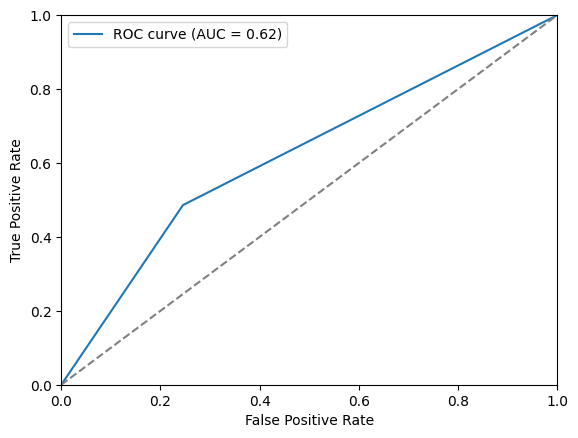

In [40]:
#################################################### Logistic regression - Oversampled Training set 
# Initialize and fit the Logistic Regression model
model = model = LogisticRegression( 
    max_iter=10000,       
    class_weight='balanced' 
)
model.fit(X_train_oversampled, y_train_oversampled)

# Predict probabilities for the positive class
y_pred_proba_LR_over = model.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred_LR_over = (y_pred_proba_LR_over >= 0.5).astype(int)

# Calculate log loss
loss = log_loss(y_test, y_pred_proba_LR_over)
print("Log Loss: {:.4f}".format(loss))

# Calculate accuracy for reference
accuracy = accuracy_score(y_test, y_pred_LR_over)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_LR_over))

# Confusion matrix for more insight
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_LR_over))

# Compute ROC curve with continuous probabilities
fpr_LR_over, tpr_LR_over, thresholds_over = roc_curve(y_test, y_pred_LR_over)
roc_auc_LR_over = auc(fpr_LR_over, tpr_LR_over)

plt.plot(fpr_LR_over, tpr_LR_over, label=f"ROC curve (AUC = {roc_auc_LR_over:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [27]:
###################################################### hyperparamtater tuning Random Foretst
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

###################################################### set the class weights here

grid_RF = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight=class_weights), 
    param_grid_RF,
    scoring='accuracy',
    n_jobs=-1
)
grid_RF.fit(X_val, y_val)

print("----- Random Forest Hyperparameter Tuning -----")
print("Best Parameters (RF):", grid_RF.best_params_)
print("Best Validation Accuracy (RF):", grid_RF.best_score_)
best_rf = grid_RF.best_estimator_


----- Random Forest Hyperparameter Tuning -----
Best Parameters (RF): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Validation Accuracy (RF): 0.7698130532610385


In [30]:
################################################# get best scores hyperparamter 
y_pred_RF = best_rf.predict_proba(X_test)[:, 1]

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_RF = (y_pred_RF >= 0.5).astype(int)

# Evaluate
accuracy_RF  = accuracy_score(y_test, y_pred_class_RF)
precision_RF = precision_score(y_test, y_pred_class_RF, zero_division=0)
recall_RF    = recall_score(y_test, y_pred_class_RF, zero_division=0)
f1_RF        = f1_score(y_test, y_pred_class_RF, zero_division=0)

Accuracy: 0.89
Precision: 0.29
Recall: 0.00
F1 Score: 0.00
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.29      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.59      0.50      0.47      7217
weighted avg       0.82      0.89      0.83      7217



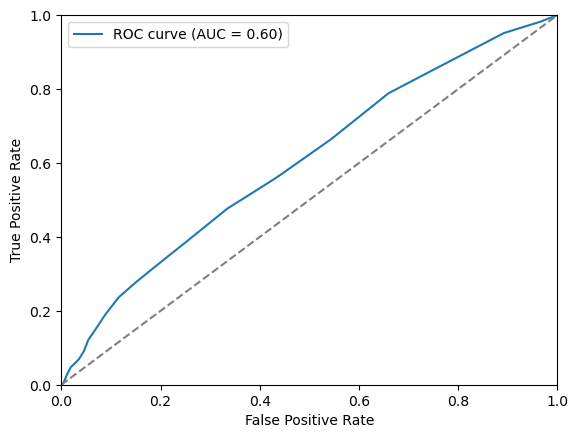

In [31]:
############################################################### print score radndom forest

print(f"Accuracy: {accuracy_RF:.2f}")
print(f"Precision: {precision_RF:.2f}")
print(f"Recall: {recall_RF:.2f}")
print(f"F1 Score: {f1_RF:.2f}")

print(classification_report(y_test, y_pred_class_RF, zero_division=0))

# Use continuous probabilities for the ROC curve
fpr_RF, tpr_RF, thresholds = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

plt.plot(fpr_RF, tpr_RF, label=f"ROC curve (AUC = {roc_auc_RF:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [32]:
############################################### hyper paramter tuning XGBoost

param_grid_XGB = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_XGB = GridSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, class_weight=class_weights),
    param_grid_XGB, 
    scoring='accuracy',
    n_jobs=-1
)

# Perform hyperparameter tuning
grid_XGB.fit(X_val, y_val)

# Print best hyperparameters and best validation accuracy
print("----- XGBoost Hyperparameter Tuning -----")
print("Best Parameters (XGB):", grid_XGB.best_params_)
print("Best Validation Accuracy (XGB):", grid_XGB.best_score_)

# Get the best model
best_xgb = grid_XGB.best_estimator_

# Predict on the test set
y_pred_XGB = best_xgb.predict_proba(X_test)[:, 1]


----- XGBoost Hyperparameter Tuning -----
Best Parameters (XGB): {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Validation Accuracy (XGB): 0.7263744019184142


C:\Users\youpz\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [33]:
############################################### running XGBoost

# Convert probabilities to binary class predictions using a threshold of 0.5
y_pred_class_XGB = [1 if prob >= 0.5 else 0 for prob in y_pred_XGB]

# Evaluate the classifier
accuracy_XGB = accuracy_score(y_test, y_pred_class_XGB)
precision_XGB = precision_score(y_test, y_pred_class_XGB, zero_division=0)
recall_XGB = recall_score(y_test, y_pred_class_XGB, zero_division=0)
f1_XGB = f1_score(y_test, y_pred_class_XGB, zero_division=0)



XGBoost Classifier Performance:
Accuracy: 0.89
Precision: 0.00
Recall: 0.00
F1 Score: 0.00

Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6394
           1       0.00      0.00      0.00       823

    accuracy                           0.89      7217
   macro avg       0.44      0.50      0.47      7217
weighted avg       0.78      0.89      0.83      7217



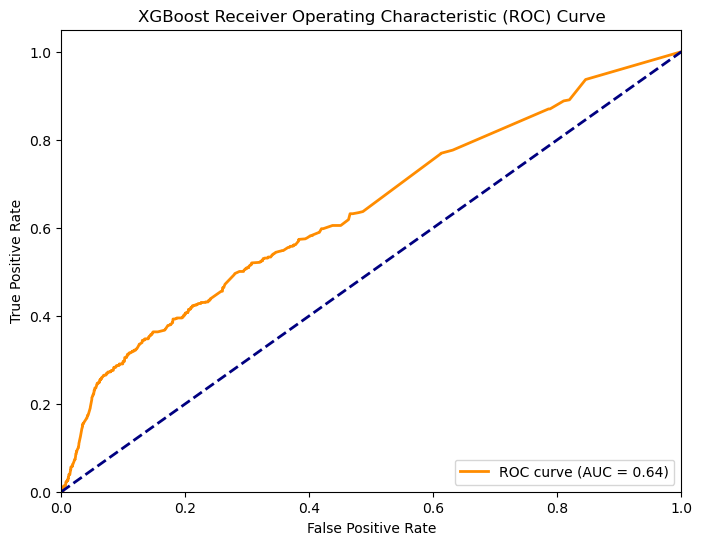

In [34]:
############################################### printing score XGBoost
print("XGBoost Classifier Performance:")
print(f"Accuracy: {accuracy_XGB:.2f}")
print(f"Precision: {precision_XGB:.2f}")
print(f"Recall: {recall_XGB:.2f}")
print(f"F1 Score: {f1_XGB:.2f}")

# Print the detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_XGB, zero_division=0))

# Compute the ROC curve and ROC-AUC using the predicted probabilities
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_XGB, tpr_XGB, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_XGB:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [56]:
################################################## make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])



c:\Users\vasso\OneDrive\Υπολογιστής\Scientific Machine Learning\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
###################################################### train model and set the class weights

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)


Epoch 1/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5542 - auc_3: 0.5710 - loss: 0.7280 - val_accuracy: 0.5942 - val_auc_3: 0.6934 - val_loss: 0.6132
Epoch 2/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6219 - auc_3: 0.6866 - loss: 0.6063 - val_accuracy: 0.6233 - val_auc_3: 0.7022 - val_loss: 0.6116
Epoch 3/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6448 - auc_3: 0.7114 - loss: 0.5968 - val_accuracy: 0.6835 - val_auc_3: 0.7278 - val_loss: 0.5697
Epoch 4/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6609 - auc_3: 0.7174 - loss: 0.5909 - val_accuracy: 0.6366 - val_auc_3: 0.7279 - val_loss: 0.5951
Epoch 5/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6509 - auc_3: 0.7283 - loss: 0.5840 - val_accuracy: 0.6765 - val_auc_3: 0.7249 - val_loss: 0.5699
Epoch 6/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6623 - auc_3: 0.7300 - loss: 0.5832 - val_accuracy: 0.6437 - val_auc_3: 0.7292 - val_loss: 0.5843
Epoc

In [58]:
####################################################### caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  # Continuous outputs, shape = (num_samples,)

# 2. Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)



226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Accuracy: 0.69
Precision: 0.19
Recall: 0.53
F1 Score: 0.28

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      6394
           1       0.19      0.53      0.28       823

    accuracy                           0.69      7217
   macro avg       0.56      0.62      0.54      7217
weighted avg       0.84      0.69      0.75      7217



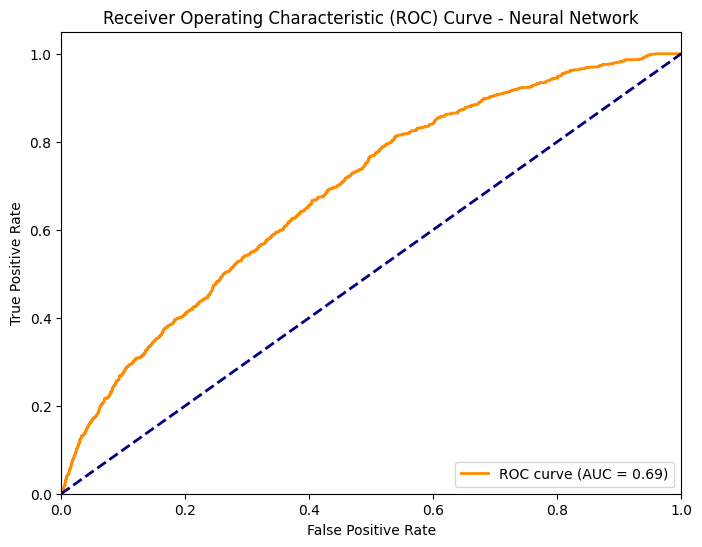

In [59]:
######################################################## print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# 5. Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

Epoch 1/50


c:\Users\vasso\OneDrive\Υπολογιστής\Scientific Machine Learning\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1245/1245 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5089 - auc_4: 0.5815 - loss: 0.7926 - val_accuracy: 0.4862 - val_auc_4: 0.6575 - val_loss: 0.6922
Epoch 2/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5480 - auc_4: 0.6700 - loss: 0.6702 - val_accuracy: 0.5403 - val_auc_4: 0.7116 - val_loss: 0.6634
Epoch 3/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5746 - auc_4: 0.6989 - loss: 0.6469 - val_accuracy: 0.5516 - val_auc_4: 0.7129 - val_loss: 0.6526
Epoch 4/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5867 - auc_4: 0.7072 - loss: 0.6299 - val_accuracy: 0.5713 - val_auc_4: 0.7292 - val_loss: 0.6430
Epoch 5/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5984 - auc_4: 0.7195 - loss: 0.6292 - val_accuracy: 0.5535 - val_auc_4: 0.7250 - val_loss: 0.6404
Epoch 6/50
1245/1245 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6088 - auc_4: 0.7282 - loss: 0.6186 - val_accuracy: 0.5783 - val_auc_4: 0.7255 - val_loss: 0.6325
Epoch 7/50
1245

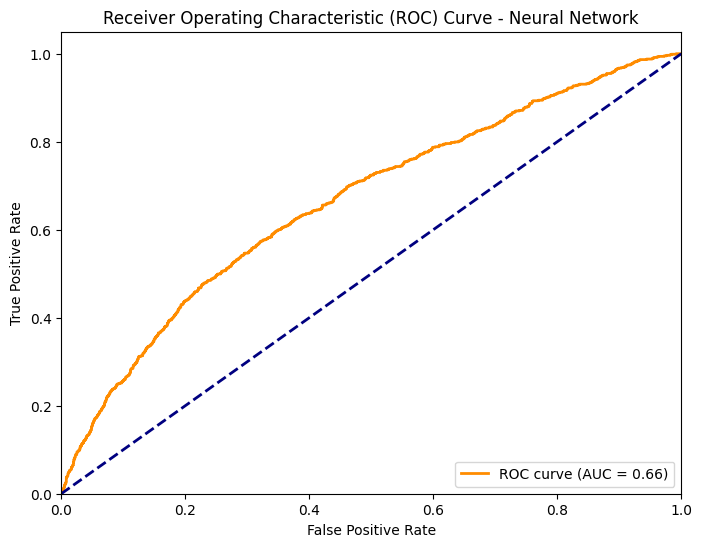

In [60]:
######################################################## Neural Network for Undersampled Train set
# Make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_undersampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


# Train model and set the class weights
history = model.fit(
    X_train_undersampled, y_train_undersampled,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)

# caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  # Continuous outputs, shape = (num_samples,)

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)

# print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()


Epoch 1/50


c:\Users\vasso\OneDrive\Υπολογιστής\Scientific Machine Learning\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1614/1614 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5631 - auc_5: 0.5744 - loss: 0.7046 - val_accuracy: 0.6049 - val_auc_5: 0.6916 - val_loss: 0.6207
Epoch 2/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6320 - auc_5: 0.6842 - loss: 0.6055 - val_accuracy: 0.6101 - val_auc_5: 0.7177 - val_loss: 0.6060
Epoch 3/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6451 - auc_5: 0.7109 - loss: 0.5909 - val_accuracy: 0.6248 - val_auc_5: 0.7369 - val_loss: 0.6021
Epoch 4/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6476 - auc_5: 0.7286 - loss: 0.5855 - val_accuracy: 0.6595 - val_auc_5: 0.7340 - val_loss: 0.5805
Epoch 5/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6629 - auc_5: 0.7277 - loss: 0.5792 - val_accuracy: 0.6240 - val_auc_5: 0.7263 - val_loss: 0.6018
Epoch 6/50
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6581 - auc_5: 0.7338 - loss: 0.5728 - val_accuracy: 0.6187 - val_auc_5: 0.7362 - val_loss: 0.5875
Epoch 7/50
1614

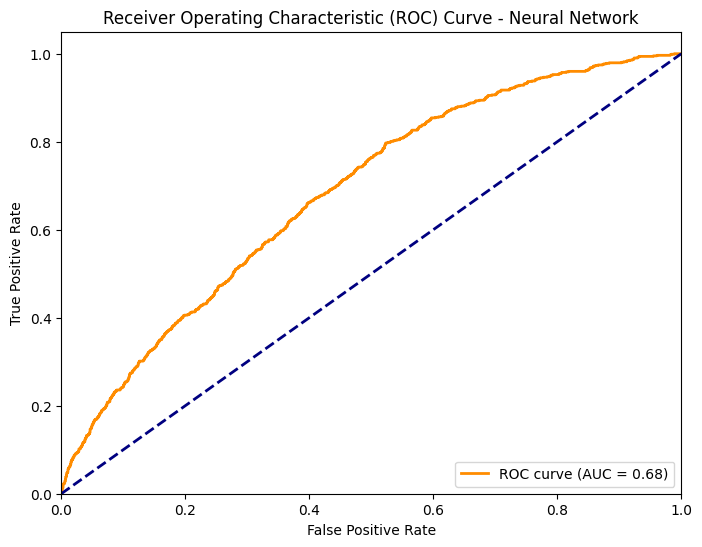

In [61]:
######################################################## Neural Network for Oversampled Train set
# Make neural netwrok
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_oversampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')  # Binary classification (0/1)
])

# Compile Model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC()])


# Train model and set the class weights
history = model.fit(
    X_train_oversampled, y_train_oversampled,
    validation_data=(X_val, y_val),
    epochs=50,  
    batch_size=32,
    verbose=1,
    class_weight=class_weights
)

# caluculate scores neural network
y_pred_probs_NN = model.predict(X_test).flatten()  # Continuous outputs, shape = (num_samples,)

# Convert probabilities to binary predictions at threshold=0.5
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)

# print scores NN
print(f"Accuracy: {accuracy_NN:.2f}")
print(f"Precision: {precision_NN:.2f}")
print(f"Recall: {recall_NN:.2f}")
print(f"F1 Score: {f1_NN:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_class_NN, zero_division=0))

# Compute and plot ROC curve (using continuous probabilities)
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()


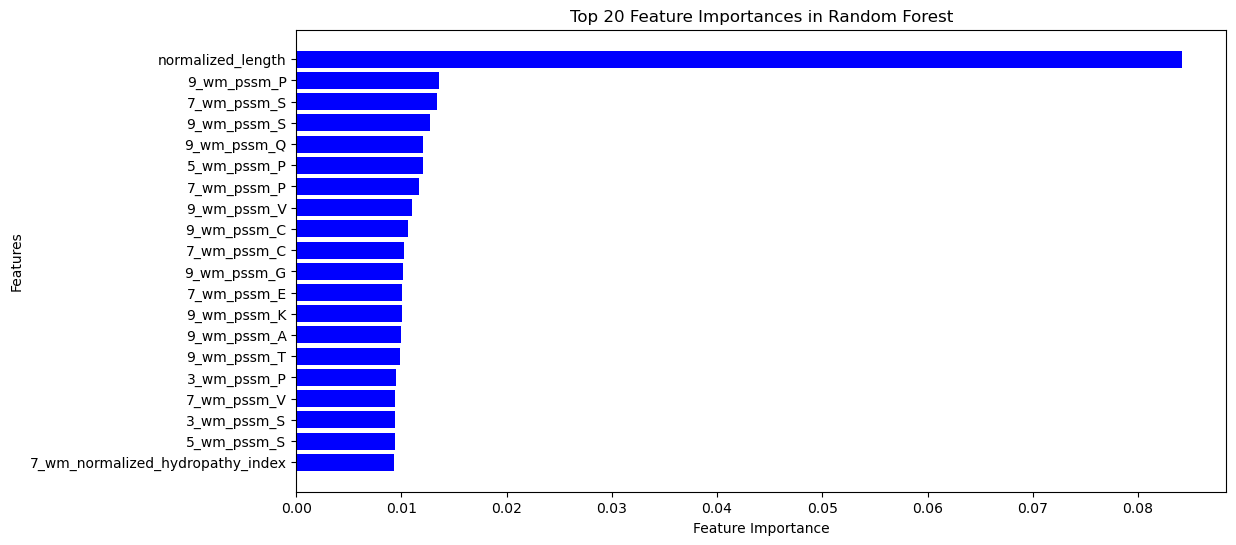

In [39]:
importances = best_rf.feature_importances_
# Ensure you have the correct feature names
train_df_test = train_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_test = train_df_test.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_train_names = pd.DataFrame(X_train, columns=feature_names_test)



# Create DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_test,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'][:20], feature_importance_df['Importance'][:20], color='blue')
plt.gca().invert_yaxis()  # Invert y-axis so the most important feature is on top
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Top 20 Feature Importances in Random Forest")
plt.show()


In [40]:
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for test data
shap_values = explainer.shap_values(X_test)

C:\Users\youpz\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(7217, 151))']
  

<Figure size 640x480 with 0 Axes>

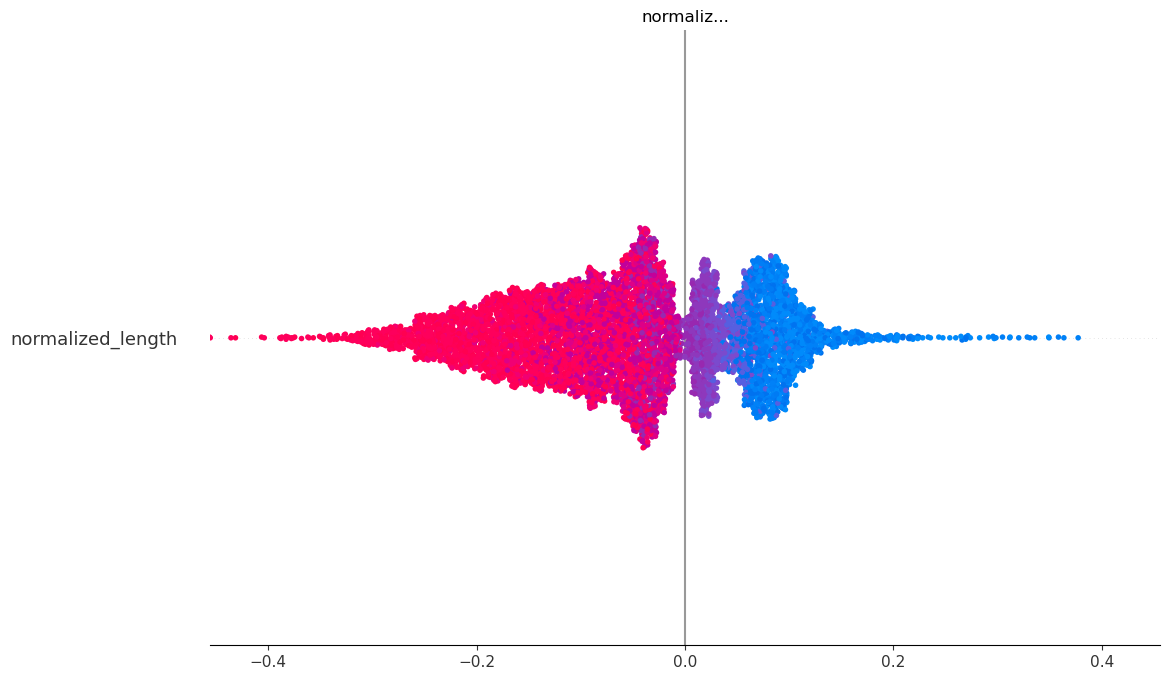

In [41]:
#global feature importance
test_df = test_df.drop(columns=[target, "uniprot_id", "domain","aa_ProtPosition", "Rlength", "Unnamed: 0"])

# Ensure feature names match X_train
feature_names_2 = test_df.columns  # Ensure X_train is a DataFrame

# Convert X_train (NumPy array) back to a DataFrame
X_test_names = pd.DataFrame(X_test, columns=feature_names_2)

# Then pass them to the summary plot:
shap.summary_plot(shap_values, X_test_names)

In [84]:
def build_model(hp):
    """Build and compile a Keras model, returning it."""
    model = Sequential()

    # Tune the number of units in the first layer
    units_input = hp.Int('units_input', min_value=128, max_value=512, step=128)
    model.add(Dense(units_input, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate
    lr = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC')]
    )
    return model

In [86]:
class MyHyperband(kt.Hyperband):
    """
    Custom Hyperband tuner that also tunes 'batch_size' via run_trial()
    and returns final metrics to avoid the 'None' return error.
    """

    def run_trial(self, trial, x, y, **fit_kwargs):
        hp = trial.hyperparameters

        # 1) Define any training-related hyperparameters here
        fit_kwargs['batch_size'] = hp.Choice('batch_size', [32, 64, 128])
        # You could also tune epochs if you want:
        # fit_kwargs['epochs'] = hp.Int('epochs', min_value=10, max_value=30, step=5)

        # 2) Build the model using the current hyperparameters
        model = self.hypermodel.build(hp)

        # 3) Train the model
        history = model.fit(x, y, **fit_kwargs)

        # 4) Retrieve final metrics from history
        #    (Make sure 'val_loss' and 'val_AUC' are being tracked!)
        final_val_loss = history.history['val_loss'][-1]
        final_val_auc  = history.history['val_AUC'][-1]

        # 5) Update the trial with these metrics so the tuner can compare
        self.oracle.update_trial(
            trial.trial_id,
            {'val_loss': final_val_loss, 'val_AUC': final_val_auc}
        )

    
        # 7) **Return** the final metrics to avoid the None return error
        return {'val_loss': final_val_loss, 'val_AUC': final_val_auc}

In [88]:
############################################## setting up and running the hyperparamter tuning


tuner = MyHyperband(
    build_model,
    objective=kt.Objective("val_AUC", direction="max"),
    max_epochs=20,   # Hyperband max epochs
    factor=3,
    overwrite=True,
    directory="my_dir",
    project_name="nn_tuning"
)

# Early stopping to avoid overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=20,                    # or the tuned value if you included 'epochs' in run_trial
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[stop_early],
    verbose=1
)


Trial 30 Complete [00h 00m 03s]
val_AUC: 0.7240417003631592

Best val_AUC So Far: 0.7356170415878296
Total elapsed time: 00h 02m 08s


In [89]:
########################################################### get paramters from hyper 
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
param_values = best_hps.values
print(param_values)


{'units_input': 128, 'learning_rate': 0.001, 'batch_size': 128, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [90]:

best_model = tuner.hypermodel.build(best_hps)

# Optionally train for more epochs with the best hyperparameters
history = best_model.fit(
    X_train, y_train,
    batch_size=best_hps.get('batch_size'),
    epochs=50,  # more epochs if you want
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[stop_early]
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.5539 - accuracy: 0.5392 - loss: 1.6329 - val_AUC: 0.6960 - val_accuracy: 0.2515 - val_loss: 1.2661
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6591 - accuracy: 0.5951 - loss: 0.9329 - val_AUC: 0.7128 - val_accuracy: 0.2154 - val_loss: 1.6050
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6876 - accuracy: 0.5766 - loss: 0.8228 - val_AUC: 0.7167 - val_accuracy: 0.1953 - val_loss: 1.7184
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.6936 - accuracy: 0.5679 - loss: 0.8010 - val_AUC: 0.7282 - val_accuracy: 0.1993 - val_loss: 1.7671


In [91]:
y_pred_probs_NN = best_model.predict(X_test).flatten()
y_pred_class_NN = (y_pred_probs_NN >= 0.5).astype(int)

accuracy_NN  = accuracy_score(y_test, y_pred_class_NN)
precision_NN = precision_score(y_test, y_pred_class_NN, zero_division=0)
recall_NN    = recall_score(y_test, y_pred_class_NN, zero_division=0)
f1_NN        = f1_score(y_test, y_pred_class_NN, zero_division=0)

print("Accuracy:", accuracy_NN)
print("Precision:", precision_NN)
print("Recall:", recall_NN)
print("F1 Score:", f1_NN)


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
Accuracy: 0.22502424830261883
Precision: 0.12617554858934169
Recall: 0.9781287970838396
F1 Score: 0.22351797862001943


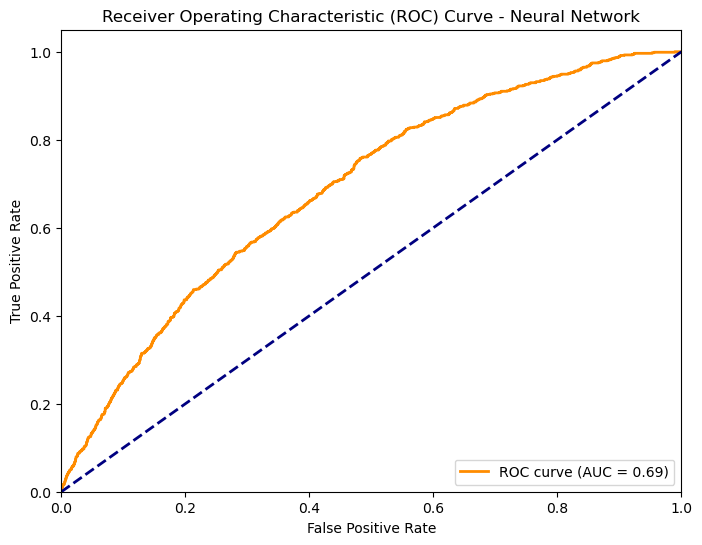

In [92]:
fpr_NN, tpr_NN, thresholds_NN = roc_curve(y_test, y_pred_probs_NN)
roc_auc_NN = auc(fpr_NN, tpr_NN)

plt.figure(figsize=(8, 6))
plt.plot(fpr_NN, tpr_NN, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_NN:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Neural Network')
plt.legend(loc='lower right')
plt.show()

In [93]:
#############################################use shap for other model

# Create SHAP DeepExplainer
explainer = shap.DeepExplainer(best_model, background)

# Compute SHAP values for test data
shap_values_2 = explainer.shap_values(X_test)

C:\Users\youpz\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_704
Received: inputs=['Tensor(shape=(100, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_704
Received: inputs=['Tensor(shape=(200, 151))']
  warnings.warn(msg)
C:\Users\youpz\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_704
Received: inputs=['Tensor(shape=(7217

<Figure size 640x480 with 0 Axes>

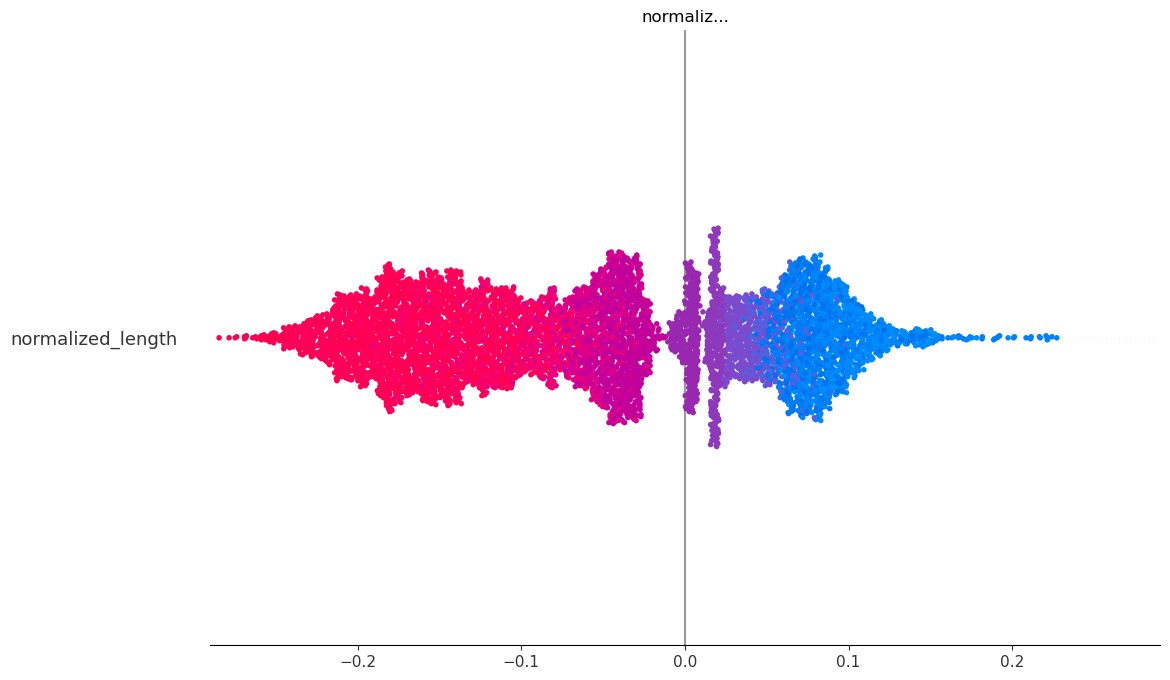

In [94]:
# Then pass them to the summary plot:
shap.summary_plot(shap_values_2, X_test_names)

In [95]:
X_train_length = X_train[:, 0].reshape(-1, 1)  
   
X_test_length  = X_test[:, 0].reshape(-1, 1) 


In [96]:
model_single = LogisticRegression()
model_single.fit(X_train_length, y_train)

LogisticRegression()

In [97]:
y_pred_probs_LR_single = model_single.predict_proba(X_test_length)[:, 1]

# Convert to binary predictions using a threshold of 0.5
y_pred_class_LR_single = (y_pred_probs_LR_single >= 0.5).astype(int)

# Evaluate with "LR_single" variable names
accuracy_LR_single  = accuracy_score(y_test, y_pred_class_LR_single)
precision_LR_single = precision_score(y_test, y_pred_class_LR_single, zero_division=0)
recall_LR_single    = recall_score(y_test, y_pred_class_LR_single, zero_division=0)
f1_LR_single        = f1_score(y_test, y_pred_class_LR_single, zero_division=0)

print("Accuracy (LR_single):", accuracy_LR_single)
print("Precision (LR_single):", precision_LR_single)
print("Recall (LR_single):", recall_LR_single)
print("F1 (LR_single):", f1_LR_single)

Accuracy (LR_single): 0.707634751281696
Precision (LR_single): 0.19047619047619047
Recall (LR_single): 0.48116646415552855
F1 (LR_single): 0.27291523087525843


              precision    recall  f1-score   support

           0       0.92      0.74      0.82      6394
           1       0.19      0.48      0.27       823

    accuracy                           0.71      7217
   macro avg       0.55      0.61      0.54      7217
weighted avg       0.83      0.71      0.75      7217



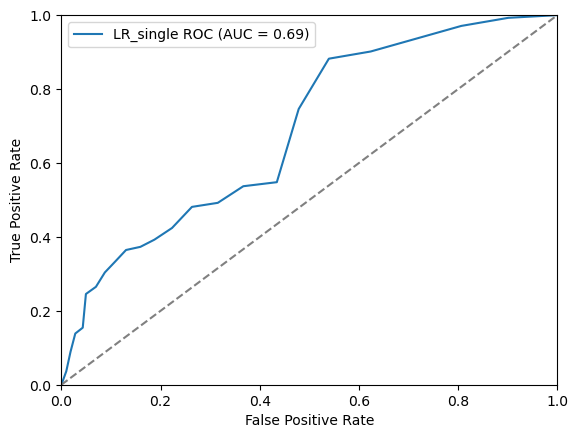

In [98]:
################################################## print results Linear regression
print(classification_report(y_test, y_pred_class_LR_single, zero_division=0))

# 2. Compute ROC curve with continuous probabilities
fpr_LR_single, tpr_LR_single, thresholds_LR_single = roc_curve(y_test, y_pred_probs_LR_single)
roc_auc_LR_single = auc(fpr_LR_single, tpr_LR_single)

# 3. Plot the ROC curve
plt.plot(fpr_LR_single, tpr_LR_single, label=f"LR_single ROC (AUC = {roc_auc_LR_single:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()